# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

Matplotlib is building the font cache; this may take a moment.


In [2]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray_data"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


/home/rhyme/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets
from helper import show_image

In [5]:
train_transform = T.Compose([
    
    T.Resize(size=(CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees =(-20,+20)),
    T.ToTensor() ,#(h,w,c) ->(c,h,w)
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

valid_transform = T.Compose([
    
    T.Resize(size=(CFG.img_size,CFG.img_size)),
    T.ToTensor(), #(h,w,c) ->(c,h,w)
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = T.Compose([
    
    T.Resize(size=(CFG.img_size,CFG.img_size)),
    T.ToTensor(), #(h,w,c) ->(c,h,w)
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
train_path = os.path.join(CFG.DATA_DIR,CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR,CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR,CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

In [8]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


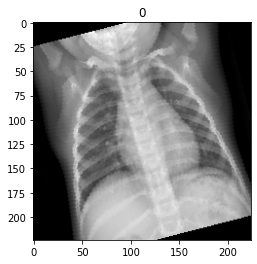

In [12]:
image,label = trainset[2]
print(trainset.class_to_idx)
class_name=['NORMAL','PNEUMONIA']
show_image(image,label)

# Load Dataset into Batches 

In [13]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [14]:
trainloader = DataLoader(trainset,batch_size = CFG.batch_size, shuffle = True)
validloader = DataLoader(validset,batch_size = CFG.batch_size, shuffle = True)
testloader = DataLoader(testset,batch_size = CFG.batch_size, shuffle = True)

In [16]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

print(len(trainset))

No. of batches in trainloader : 326
No. of Total examples : 5216
5216


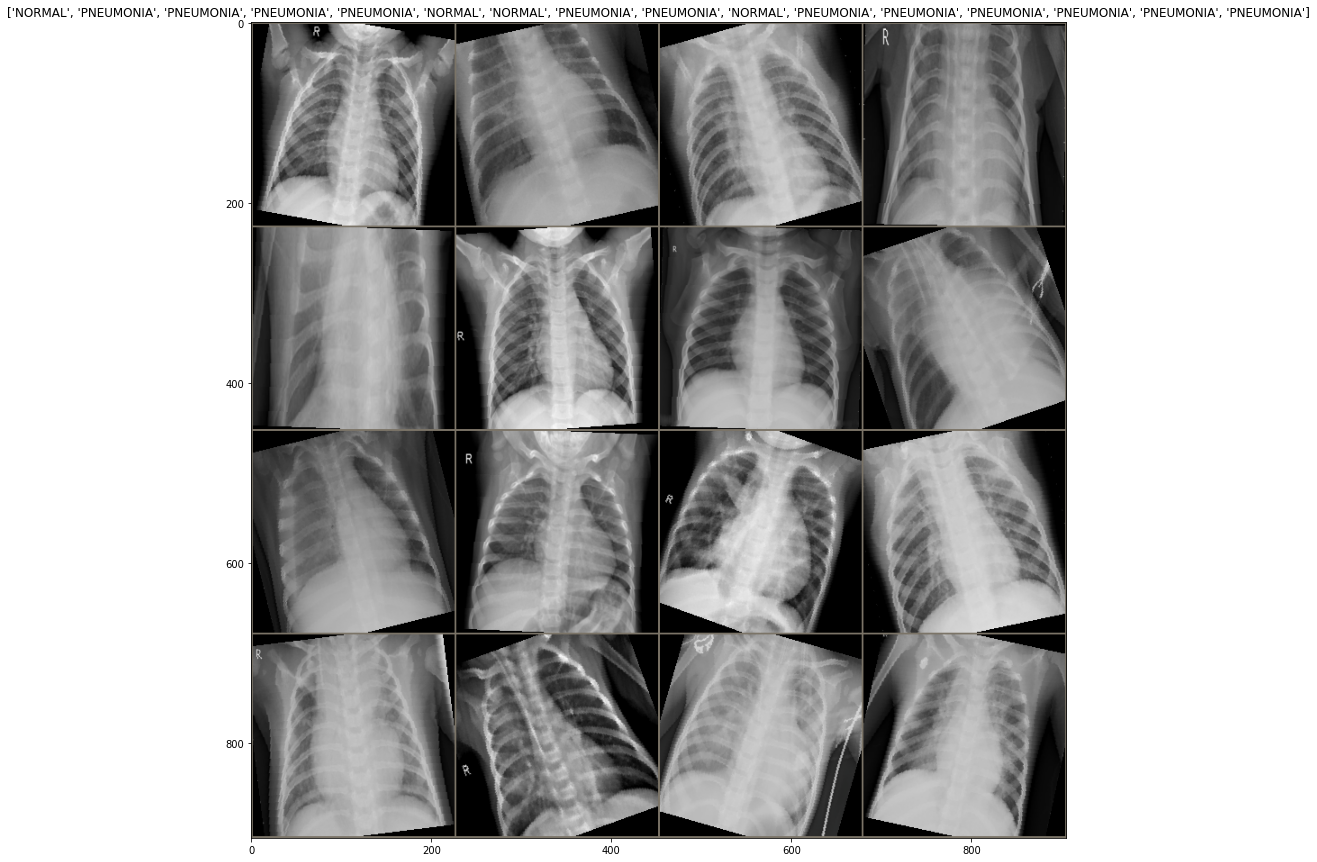

In [18]:
dataiter = iter(trainloader)
images,labels=dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title=[class_name[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [27]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2)
    
)

In [28]:
from torchsummary import summary 
summary(model, input_size = (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
    SqueezeExcite-10         [-1, 48, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           1,152
      BatchNorm2d-12         [-1, 24, 112, 112]              48
         Identity-13         [-1, 24, 112, 112]               0
DepthwiseSeparableConv-14         [-1, 

# Build a Simple Trainer

In [30]:
from helper import accuracy
from tqdm import tqdm

In [31]:
class PneumoniaTrainer():
    
    def __init__(self,criterion,optimizer,schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    def train_batch_loop(self,model,trainloader):
        
        train_acc = 0
        train_loss=0
        
        for images, labels in tqdm(trainloader):
            
            images= images.to(device)
            labels= labels.to(device)
            
            logits=model(images)
            loss= self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss +=loss.item()
            train_acc +=accuracy(logits,labels)
            
        return train_acc/len(trainloader),train_loss/len(trainloader)

    
    def valid_batch_loop(self,model,validloader):
        
        valid_acc=0
        valid_loss=0
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels= labels.to(device)
            
            logits = model(images)
            loss= self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
            return valid_acc/len(validloader),valid_loss/len(validloader)
        
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        model = model.to(device)
        valid_min_loss = np.Inf
        
        for i in range(epochs):
            
            model.train()
            
            avg_train_acc, avg_train_loss = self.train_batch_loop(model,trainloader)
            model.eval()
            avg_valid_acc,avg_valid_loss=self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss:
                
                print("Valid loss decreased {} --> {}".format(valid_min_loss,avg))
                
                torch.save(model.state.dict(),'PenumoniaModel.pt')
                
            print("Epoch : {} Train Loss : {} Train Acc : {}".format(i+1,avg_train_loss,avg_train_acc))
            print("Epoch : {} Valid Loss : {} Valid Acc : {}".format(i+1,valid_train_loss,valid_train_acc))
            

# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=CFG.lr)
schedular= None

trainer=PneumoniaTrainer(criterion,optimizer,schedular)
trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)

 26%|██▌       | 85/326 [07:35<21:30,  5.35s/it]


KeyboardInterrupt: 

# Plot Results 

In [35]:
from helper import view_classify

model.load_state_dict(torch.load('ColabPneumoniaModel.pt',map_location='cpu'))

model.eval()
avg_test_acc,avg_test_loss=trainer.valid_batch_loop(model,testloader)


print("Test Acc: {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

  0%|          | 0/39 [00:05<?, ?it/s]

Test Acc: 0.024038461968302727
Test Loss : 0.003239953365081396


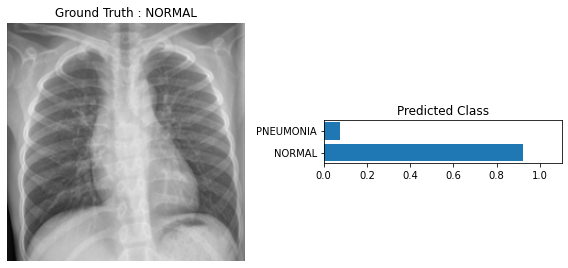

In [37]:
image,label = testset[3]

logit = model(image.unsqueeze(0)) #(3,224,224) -> (1,3,224,224)
ps = F.softmax(logit,dim = 1)

view_classify(image,ps,label)